# Content Mining Models

## Table of Contents
##### [1. Data Preprocessing and Imports](#preprocessing)
##### [1.1 Keyword extraction](#sampling)
##### [1.1 Keyword extraction](#keywords)
##### [2. Models](#models)
###### [2.1. Cosine Similarity](#cosine)
###### [2.2. LSI Model](#lsi)
###### [2.3. Mixture Model](#mixture)
##### [3. Interpretation and Evaluation](#interpretation_evaluation)

<a id='preprocessing'></a>
## 1. Data Preprocessing and Imports

##### Packages to install in cmd upfront:

conda install -c conda-forge selenium <\br>
conda install -c anaconda nltk <\br>
pip install rake-nltk

In [199]:
import pandas as pd
import numpy as np
import nltk
import inflect
import re, string, unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.metrics import jaccard_score, pairwise_distances_chunked, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from IPython.display import HTML

In [200]:
# Import functions module
%run functions.py

In [184]:
#load data
interactions_raw = pd.read_csv(
        './Data/RAW_interactions.csv')
recipes_raw = pd.read_csv(
        './Data/RAW_recipes.csv', parse_dates=['submitted'], infer_datetime_format=True)

In [185]:
#make copies so that we don't have to reload the data after mistakes
interactions_data = interactions_raw.copy()
recipes_data = recipes_raw.copy()

In [186]:
# Rename columns to more explanatory names
recipes_data.rename(columns={"id": "recipe_id"}, inplace=True)

# Fill nan
# recipes_data.fillna("", inplace=True)
# interactions_data.fillna("", inplace=True)

In [187]:
deal_with_NAs(recipes_data)

<a id='sampling'></a>
### Provisory recipe filter/sampler 

In [188]:
#create an age column for the recipes
recipes_data['age'] = round((2019-recipes_data.submitted.dt.year)+recipes_data.submitted.dt.month/12, 1)

In [189]:
recipes_data = get_avg_recipe_rating(interactions_data, recipes_data)
filter_byinteractions(15,8,recipes_data, older=True)
filter_byinteractions(10,8,recipes_data, older=False)
filter_byquality(recipes_data)
remove_duplicates(recipes_data)
recipes_data = generate_URL(recipes_data)

Shape after filtering recipes less than 15 and older than 8 years old: (21913, 15)
Shape after filtering recipes less than 10 and younger than 8 years old: (11151, 15)
Shape after removing 1 step recipes w/ low interactions: (11151, 15)
Shape after removing recipes w/o ratings: (11151, 15)
Shape after removing 0 minutes interaction w/ low interactions: (11103, 15)
Shape after dropping duplicates: (11090, 15)
URLs created for each of the 11090 recipes


In [190]:
recipes_data.head()

,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,age,num_interactions,avg_rating,URL
15,chicken lickin good pork chops,63986,500,14664,2003-06-06,"['weeknight', 'time-to-make', 'course', 'main-...","[105.7, 8.0, 0.0, 26.0, 5.0, 4.0, 3.0]",5,"['dredge pork chops in mixture of flour , salt...",here's and old standby i enjoy from time to ti...,"['lean pork chops', 'flour', 'salt', 'dry must...",7,16.5,19,4.88,https://www.food.com/recipe/chicken-lickin-goo...
36,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...","[166.1, 16.0, 6.0, 32.0, 19.0, 26.0, 3.0]",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...","['frozen chopped spinach', 'egg', 'salt', 'bla...",8,17.3,113,4.34,https://www.food.com/recipe/how-i-got-my-famil...
43,immoral sandwich filling loose meat,58224,35,37183,2003-04-04,"['60-minutes-or-less', 'time-to-make', 'course...","[223.2, 22.0, 4.0, 7.0, 35.0, 30.0, 0.0]",6,"['brown the meat & drain fat', 'stir in sugar ...",just the thing for a day when you're wanton so...,"['ground beef', 'sugar', 'prepared yellow must...",8,16.3,21,4.20,https://www.food.com/recipe/immoral-sandwich-f...
53,land of nod cinnamon buns,22526,35,29212,2002-03-14,"['60-minutes-or-less', 'time-to-make', 'course...","[575.3, 18.0, 116.0, 34.0, 28.0, 22.0, 34.0]",7,"['before you turn in for the night , grease a ...",i have made this several times and it's dead e...,"['rolls', 'brown sugar', 'instant vanilla pudd...",6,17.2,51,4.73,https://www.food.com/recipe/land-of-nod-cinnam...
67,never weep whipped cream,74805,5,87877,2003-11-01,"['15-minutes-or-less', 'time-to-make', 'course...","[276.3, 45.0, 2.0, 1.0, 3.0, 91.0, 0.0]",4,['whip all ingredients together until firm pea...,"i don't know where i got this, but it works. t...","['whipping cream', 'vanilla instant pudding mi...",4,16.9,80,4.99,https://www.food.com/recipe/never-weep-whipped...


<a id='keywords'></a>
### Keyword extraction

In [ ]:
# Preprocess ingredients and save as String
for index, row in recipes_data.iterrows():
    ingredientlist = row['ingredients']
    ingredientlist = row['ingredients'].replace('[', '').replace(', ', '').replace(']', '').replace('and', '\'').split("\'")
    ingredientlist = list(filter(None, ingredientlist))
    ingredientlistString = ""
    for i in ingredientlist:
        ingredientlistString = ingredientlistString + i
    recipes_data.at[index, 'ingredients'] = ingredientlistString

In [166]:
# Extract keywords for free text features
# recipes_data = get_keywords(recipes_data, "steps", "steps_keywords")
# recipes_data = get_keywords(recipes_data, "description", "description_keywords")
# interactions_data = get_keywords(interactions_data, "review", "review_keywords")

In [167]:
recipes_data.head(3)

,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,age,num_interactions,avg_rating,URL
15,chicken lickin good pork chops,63986,500,14664,2003-06-06,"['weeknight', 'time-to-make', 'course', 'main-...","[105.7, 8.0, 0.0, 26.0, 5.0, 4.0, 3.0]",5,"['dredge pork chops in mixture of flour , salt...",here's and old standby i enjoy from time to ti...,lean pork chopsfloursaltdry mustardgarlic powd...,7,16.5,19,4.88,https://www.food.com/recipe/chicken-lickin-goo...
36,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...","[166.1, 16.0, 6.0, 32.0, 19.0, 26.0, 3.0]",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...",frozen chopped spinacheggsaltblack pepperonion...,8,17.3,113,4.34,https://www.food.com/recipe/how-i-got-my-famil...
43,immoral sandwich filling loose meat,58224,35,37183,2003-04-04,"['60-minutes-or-less', 'time-to-make', 'course...","[223.2, 22.0, 4.0, 7.0, 35.0, 30.0, 0.0]",6,"['brown the meat & drain fat', 'stir in sugar ...",just the thing for a day when you're wanton so...,ground beefsugarprepared yellow mustardbeercay...,8,16.3,21,4.20,https://www.food.com/recipe/immoral-sandwich-f...


<a id='user-interaction'></a>
### Creating user-activity data & filtered interactions data

Filter data flow:

filter_interactions_data() -(calls)-> 
    (impute_average_rating(), (create_activity_data() 
                                        -(calls)-> get_user_activity_df())

In [191]:
def impute_average_rating(row, df_uactivity):
    if (row['rating'] == 0):
        imputed_rating = round(df_uactivity.loc[df_uactivity.user_id == row.user_id, 'uavg_rating'].values[0], 0)
        return imputed_rating
    else:
        return row.rating

def get_user_activity_df(df):
    #Create a user activity dataframe
    df_uactivity = df.groupby('user_id')['rating'].value_counts().unstack().fillna(0)
    cols = list(df_uactivity)
    df_uactivity['total_interactions'] = df_uactivity[cols].sum(axis=1)
    df_uactivity['total_ratings'] = df_uactivity['total_interactions']-df_uactivity[0]
    return df_uactivity

def create_activity_data(interactions_df, num_interactions):
    df_uactivity = get_user_activity_df(interactions_df[['recipe_id','user_id', 'rating']])
    df_uactivity = df_uactivity[df_uactivity['total_interactions']>=7]
    print(f'Shape after filtering out users with less than {num_interactions} interactions: {df_uactivity.shape}')
    #create average user ratings as behavior
    df_uactivity['uavg_rating'] = df_uactivity.iloc[:,1:6].apply(
        lambda row: np.round(np.ma.average(list(range(1,6)), 
                                           weights = (row[1], row[2], row[3], row[4], row[5])),1), axis = 1)
    
    df_uactivity = df_uactivity.reset_index()
    df_uactivity.columns.set_names(None, inplace = True)
    
    #drop users that only have only reviews but no ratings
    df_uactivity.drop(df_uactivity[df_uactivity.total_ratings == 0].index, inplace=True, axis=0)
    return df_uactivity

def filter_interactions_data(interactions_df, recipes_data, num_interactions):
    df_uactivity = create_activity_data(interactions_df, num_interactions)
    # 1. Create Filter for interations with filtered df_uactivity -> Only interactions from active users remain
    user_filter = pd.merge(df_uactivity[['user_id']], interactions_data[['recipe_id','user_id', 'rating']], how = 'left', on ='user_id')
    # 2. Filter interactions with active recipes -> Only interactions from active users and clean recipes remain
    interactions = pd.merge(recipes_data[['recipe_id']], user_filter[['recipe_id', 'user_id', 'rating']], on = 'recipe_id', how ='inner')
    zero_ratings = len(interactions.loc[interactions.rating==0])
    interactions['rating'] = interactions.apply(lambda row: impute_average_rating(row, df_uactivity), axis=1)
    print(f'Number of imputed ratings: {zero_ratings}')
    return interactions

In [192]:
interactions = filter_interactions_data(interactions_data, recipes_data, num_interactions=7)
interactions.head()

Shape after filtering out users with less than 7 interactions: (17099, 8)
Number of imputed ratings: 8169


,recipe_id,user_id,rating
0,63986,4470,5.0
1,63986,28649,4.0
2,63986,37471,5.0
3,63986,60992,5.0
4,63986,75497,5.0


Percent of 5 star rating interactions: 79.63%
Percent of 4 star rating interactions: 15.58%
Percent of 3 star rating interactions: 3.29%
Percent of 2 star rating interactions: 1.03%
Percent of 1 star rating interactions: 0.47%


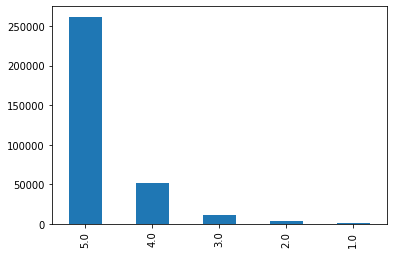

In [193]:
#Let's look at the distribution of ratings
get_rating_dist(interactions.rating)

### NLP Preprocessing

In [194]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Andi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [195]:
def create_input (df, column_names):
    df_content = df
    df_content['content'] = df.loc[:, (column_names)].apply(lambda texts: ' '.join(texts), axis=1)
    df_content.drop(columns = column_names, inplace = True)
    df_content['content']=df_content['content'].apply(lambda text: ' '.join(text.split()))
    return df_content

In [196]:
#checking if all recipes are in interactions
helper = pd.unique(interactions_data['recipe_id'])
df_rfiltered = recipes_data[recipes_data.recipe_id.isin(helper)]
print(recipes_data.shape)
df_rfiltered.shape

(11090, 16)


(11090, 16)

In [197]:
#flatten steps data
df_rfiltered.steps = df_rfiltered.loc[:, ('steps')].str.replace("\[", "").str.replace("'", "").str.replace("\]", "").str.replace(",","").copy()

#create content df
df_rfiltered = create_input(df_rfiltered[['recipe_id', 'name', 'description', 'steps']], ['name', 'description', 'steps'])

df_rfiltered.head()

,recipe_id,content
15,63986,chicken lickin good pork chops here's and old ...
36,25775,how i got my family to eat spinach spinach cas...
43,58224,immoral sandwich filling loose meat just the t...
53,22526,land of nod cinnamon buns i have made this sev...
67,74805,never weep whipped cream i don't know where i ...


In [198]:
#now process content
content_processed = get_processed(df_rfiltered)
content_processed.shape

KeyboardInterrupt: 

<a id='models'></a>
## 2. Models

### 2.0 General functions

### 2.0.1 Recommendations functions for Coverage & Personalization

In [176]:
#return top k predicted ratings in readable form 

# IMPORTANT: must set the dataframe for recipe_info index == recipe_id!
def get_user_recommendations(user_id, similarity, content, interactions, recipe_info, k):
    """
     Returns
    ----------
    info:
        HTML dataframe with recommendation information
    """
    #get top k recipe ids
    topk_recipes, predictions, recipeurls, imageurls = get_topk_recipes(user_id, similarity, content, interactions, k)
    info = recipe_info.loc[topk_recipes]
    info = info[['name', 'minutes', 'submitted', 'description']]
    info['prediction'] = predictions
    info['recipeurl'] = recipeurls
    info['imageurl'] = imageurls
    for index, row in info.iterrows():
        info.at[index, 'recipeurl'] = '<a href="'+ row['recipeurl'] + '">'+row['recipeurl'] +'</a>'
        info.at[index, 'imageurl'] = '<a href="'+ row['imageurl'] + '"> Image of recipe '+str(index)+'</a>'
    info = HTML(info.to_html(escape=False))
    return info

def get_topk_recipes(user_id, similarity, content, interactions, k):
    """
     Returns
    ----------
    topk_recipes:
        array of top k recipe ids
    predictions:
        array with top k predictions
    recipeurls:
        array with top k recipe urls
    imageurls:
        array with top k recipe imageurls
    """
    prediction_df = get_user_preference(user_id,similarity, content, interactions)
    #take only the not yet seen recipes
    new_predictions = prediction_df[prediction_df['has_rated'] == False]
    #sort predictions
    ordered_predictions = new_predictions.sort_values(by='prediction', ascending=False)
    #get recipe_id array
    topk_recipes = ordered_predictions.index[:k].values
    imageurls = []
    recipeurls = []
    for entry in topk_recipes:
        recipeurls.append("https://www.food.com/recipe/" + str(entry))
        imageurls.append(get_image_source_url(entry))
    predictions = ordered_predictions.prediction[:k].values
    return topk_recipes, predictions, recipeurls, imageurls

#return predictions for 1 user
def get_user_preference(user_id, similarity, content, interactions_data):
    """
     Returns
    ----------
    prediction_df:
        DataFrame in with columns ['recipe_id','prediction', 'has_rated'] for 1 user
    """
    #prepare similarity dataframe
    sim = pd.DataFrame(similarity, index=content['recipe_id'].values, columns=content['recipe_id'].values)
    #get already rated recipes of user
    rated_recipes = interactions_data.loc[interactions_data['user_id']==user_id, 'recipe_id'].values
    #get similarities of ALL recipes w/ already rated recipes of user
    sim_rated_all = sim.loc[rated_recipes, :]
    #get ratings of already rated recipes
    ratings = get_reshaped_ratings(user_id, interactions_data)
    
    #compute weighted similarities between all recipes and already rated recipes
    weighted_sim = np.dot(ratings,sim_rated_all)
    #compute normalization constant
    norm_const = np.array(np.abs(sim_rated_all).sum(axis=0))
    #return sorted predictions
    pref_predictions = weighted_sim/norm_const
    
    flat_predictions = [item for sublist in pref_predictions for item in sublist]
    #return df with recipe id also
    prediction_df = pd.DataFrame(flat_predictions, index =content['recipe_id'].values, columns =['prediction'])
    #indicate the already tried recipes
    prediction_df['has_rated'] = prediction_df.index.isin(rated_recipes)
    #order predictions
    return prediction_df

#arrange ratings for matrix multiplication
def get_reshaped_ratings(user_id, interactions_data):
    ratings = interactions_data[interactions_data['user_id']==user_id]
    ratings.set_index('recipe_id', inplace=True)
    ratings.index.set_names(None, inplace = True)
    ratings.drop(columns='user_id', inplace=True)
    ratings = ratings.transpose()
    ratings.rename(index={'rating':user_id}, inplace=True)
    return ratings

In [177]:
from progressbar import ProgressBar

def make_all_recommendations(user_ids, similarity, content, interactions, k):
    """
    Params
    --------
    user_ids: Array
        list of user ids
    similarity: Array 
        similarity matrix with shape (#recipes, #recipes).
    content: DataFrame
        processed DataFrame with ['recipe_id', 'content'] used to fetch all recipes ids to make recommendations for 
        (=total training data)
    interactions: DataFrame
        preprocessed interactions DataFrame ['recipe_id', 'user_id', 'rating']     
    k: integer
        number of recommendations to make
    Returns:
    --------
    nested_recommendations:
        nested list of recommended recipe_ids for each user in param list
        example:[[rid1, rid20, rid30...], [rid1, rid20, rid30...],[rid1, rid20, rid30...]]
    """
    pbar = ProgressBar()
    nested_recommendations=[]
    for i in pbar(range(len(user_ids))):
        recs = get_topk_recipes_lean(user_ids[i], similarity, content, interactions, k)
        nested_recommendations.append(recs)
    return nested_recommendations

def get_topk_recipes_lean(user_id, similarity, content, interactions, k):
    """
     Returns
    ----------
    topk_recipes:
        array of top k recipe ids
    predictions:
        array with top k predictions
    recipeurls:
        array with top k recipe urls
    imageurls:
        array with top k recipe imageurls
    """
    prediction_df = get_user_preference(user_id,similarity, content, interactions)
    #take only the not yet seen recipes
    new_predictions = prediction_df.loc[prediction_df['has_rated'] == False, :]
    #sort predictions
    ordered_predictions = new_predictions.sort_values(by='prediction', ascending=False)
    #get recipe_id array
    topk_recipes = ordered_predictions.index[:k].values
    #predictions = ordered_predictions.prediction[:k].values
    return topk_recipes

# def get_user_recommendations_lean(user_id, similarity, content, interactions, recipe_info, k):
#     """
#      Returns
#     ----------
#     info:
#         HTML dataframe with recommendation information
#     """
#     #get top k recipe ids
#     topk_recipes, predictions = get_topk_recipes_lean(user_id, similarity, content, interactions, k)
#     info = recipe_info.loc[topk_recipes]
#     info = info[['name', 'minutes', 'submitted', 'description']]
#     info['prediction'] = predictions
#     return info

In [178]:
#Source: https://github.com/statisticianinstilettos/recmetrics/
import random
import scipy.sparse as sp

# input = nested_recommendations from make_all_recommendations
def catalog_coverage(predicted, catalog, k):
    """
    Computes the catalog coverage for k lists of recommendations
    Parameters
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    catalog: list
        A list of all unique items in the training data
        example: ['A', 'B', 'C', 'X', 'Y', Z]
    k: integer
        The number of observed recommendation lists
        which randomly choosed in our offline setup
    Returns
    ----------
    catalog_coverage:
        The catalog coverage of the recommendations as a percent
        rounded to 2 decimal places
    ----------    
    Metric Defintion:
    Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
    Beyond accuracy: evaluating recommender systems by coverage and serendipity.
    In Proceedings of the fourth ACM conference on Recommender systems (pp. 257-260). ACM.
    """
    sampling = random.choices(predicted, k=k)
    predicted_flattened = [p for sublist in sampling for p in sublist]
    L_predictions = len(set(predicted_flattened))
    catalog_coverage = round(L_predictions/(len(catalog)*1.0)*100,2)
    return catalog_coverage

def personalization(predicted):
    """
    Personalization measures recommendation similarity across users.
    A high score indicates good personalization (user's lists of recommendations are different).
    A low score indicates poor personalization (user's lists of recommendations are very similar).
    A model is "personalizing" well if the set of recommendations for each user is different.
    Parameters:
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        The personalization score for all recommendations.
    """

    def make_rec_matrix(predicted):
        df = pd.DataFrame(data=predicted).reset_index().melt(
            id_vars='index', value_name='item',
        )
        df = df[['index', 'item']].pivot(index='index', columns='item', values='item')
        df = pd.notna(df)*1
        rec_matrix = sp.csr_matrix(df.values)
        return rec_matrix

    #create matrix for recommendations
    predicted = np.array(predicted)
    rec_matrix_sparse = make_rec_matrix(predicted)

    #calculate similarity for every user's recommendation list
    similarity = cosine_similarity(X=rec_matrix_sparse, dense_output=False)

    #get indicies for upper right triangle w/o diagonal
    upper_right = np.triu_indices(similarity.shape[0], k=1)

    #calculate average similarity
    personalization = np.mean(similarity[upper_right])
    return 1-personalization

### 2.0.2 Prediction function for RMSE

In [179]:
#prediction for 1 already rated recipe based on similarities to other already rated recipes

def get_one_prediction(similarity, content, interactions, user_id, recipe_id):
    sim = pd.DataFrame(similarity, index=content['recipe_id'].values, columns=content['recipe_id'].values)
    #get already rated recipes of user
    rated_recipes = interactions[interactions['user_id']==user_id]['recipe_id'].values
    #get similarities of to be predicted recipe rating with already rated recipes by user x
    sim_rated = sim.loc[sim.index==recipe_id, rated_recipes].loc[recipe_id].values
    #get ratings of rated recipes
    ratings = interactions[interactions['user_id']==user_id]['rating'].values
    
    actual = interactions.loc[(interactions.user_id==user_id) & (interactions.recipe_id==recipe_id)]['rating'].values[0]
    prediction = np.dot(ratings, sim_rated) /np.array([np.abs(sim_rated).sum(axis=0)])
    return actual, prediction

In [180]:
def make_all_predictions(num_interactions, similarity, content, interactions, uid_array, rids_array):
    predictions_cos = []
    actual_cos = []
    pbar = ProgressBar()
    
    for i in pbar(range(num_interactions)):
        act, pred = get_one_prediction(similarity, content, interactions, uid_array[i], rids_array[i])
        predictions_cos.append(pred)
        actual_cos.append(act)
        
    return predictions_cos, actual_cos


In [181]:
#only relevant if there is a recipe sample

def get_interaction_processed(processed, interactions):
    #fetch only interactions in the preprocessed sample
    interactions_processed = interactions.loc[interactions.recipe_id.isin(processed.recipe_id)]\
                           .reset_index()\
                           .drop(columns=['index'])
    print(f'Interactions before processing: {len(interactions.index)}\nInteractions covered in sample: {len(interactions_processed.index)}')
    return interactions_processed

<a id='cosine'></a>
### 2.1. Cosine similarity

#### 2.1.1 Tfidf & SVD

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [45]:
def get_cos_sim_matrix(processed, n_components):
    tfidf = TfidfVectorizer(stop_words='english')
    processed['content'] = processed['content'].fillna('')
    tfidf_matrix = tfidf.fit_transform(processed['content'])
    #reduce dimensionality of tfidf matrix
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    tfidf_truncated = svd.fit_transform(tfidf_matrix) 
    cosine_sim = cosine_similarity(tfidf_truncated,tfidf_truncated)
    return cosine_sim

In [46]:
cosine_sim = get_cos_sim_matrix(content_processed, 10)
cosine_sim.shape

(11090, 11090)

#### 2.1.1.1 Make all recommendations for tfidf/SVD

In [47]:
pd.set_option('mode.chained_assignment', None)

nested_recommendations = make_all_recommendations(interactions['user_id'].drop_duplicates().values, cosine_sim, content_processed, interactions, 5)

KeyboardInterrupt: 

In [ ]:
catalog_coverage(nested_recommendations, content_processed.recipe_id.values, 5)

In [ ]:
personalization(nested_recommendations)

#### 2.1.1.2 Make all predictions for tfidf/SVD

In [ ]:
predictions_cos, actual_cos = make_all_predictions(len(interactions), cosine_sim, content_processed, interactions, 
                                            interactions['user_id'].values, interactions['recipe_id'].values)

In [ ]:
rmse_cos = mean_squared_error(predictions_cos, actual_cos)**0.5
mae_cos = mean_absolute_error(predictions_cos, actual_cos)
print(f'RMSE: {rmse_cos}, MAE: {mae_cos}')

In [ ]:
interactions['predicted_rating'] = [item for sublist in predictions_cos for item in sublist]
get_rating_dist(round(interactions.predicted_rating))

#### 2.1.1.3 Optimize n_components of tfidf/SVD

In [ ]:
#TODO

In [101]:
def tuning_cos_param(n_components, similarity, content, interactions, uid_array, rids_array):
    rmse_mix = []
    
    predictions, actuals = make_all_predictions(num_interactions, similarity, content, interactions, uid_array, rids_array)
    rmse = mean_squared_error(predictions, actuals)**0.5
    rmse_mix.append(rmse)
    return rmse_mix

In [ ]:
def tuning_cos_param(n_components, content, interactions, uid_array, rids_array, k):
    rmse_cos = []
    coverage_cos = []
    personalization_cos =[]
    
    for n in n_components:
        similarity = get_cos_sim_matrix(content, n_components)
        
        predictions, actuals = make_all_predictions(num_interactions, similarity, content, interactions, uid_array, rids_array)
        rmse = mean_squared_error(predictions, actuals)**0.5
        rmse_cos.append(rmse)
        
        nested_recommendations = make_all_recommendations(uid_array.drop_duplicates(), 
                                                          similarity, 
                                                          content, 
                                                          interactions, 
                                                          k)
        coverage = catalog_coverage(nested_recommendations, content.recipe_id.values, k)
        pers = personalization(nested_recommendations)
        
        coverage_cos.append(coverage)
        personalization_cos.append(pers)
           
return rmse_cos, coverage_cos, personalization_cos

In [ ]:
rmse_cos_tune, coverage_cos_tune, personalization_cos = tuning_mix_param(n_components,
                                                                         cosine_sim,
                                                                         content_processed,
                                                                         interactions,
                                                                         uid_array,
                                                                         rids_array)
rmse_cos_min = min(rmse_cos_tune)
rmse_cos_min_idx = rmse_cos_tune.index(rmse_cos_min)
n_components_min = n_components[rmse_cos_min_idx]

In [ ]:
plt.plot(n_components, rmse_cos_tune)
plt.xlabel('n_components')
plt.ylabel('RMSE')
plt.title('RMSE for different tfidv/SVD models')
plt.plot([n_components_min], [rmse_cos_min], 'o')
plt.show()

#### 2.1.2 WordEmbeddings

In [209]:
content_comma_separated = [content_item.split(" ") for content_item in content_processed["content"]]

In [210]:
from gensim.models import Word2Vec 
model = Word2Vec(content_comma_separated, size=100)
word2vector = dict(zip(model.wv.index2word, model.wv.syn0))

C:\Users\Andi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [211]:
import collections

# Calculate tfidf vector
tfidf = TfidfVectorizer(analyzer=lambda x: x)
tfidf.fit(content_comma_separated)

# if a word was never seen - it must be at least as infrequent
# as any of the known words - so the default idf is the max of 
# known idf's
max_idf = max(tfidf.idf_)
# Generate word2word matrix
word2word = collections.defaultdict(
    lambda: max_idf,
    [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

# if a text is empty we should return a vector of zeros
# with the same dimensionality as all the other vectors
dim = len(w2v.items())
# Generate tfidf matrix
tfidf_matrix = np.array([
    np.mean([word2vector[w] * word2word[w]
             for w in words if w in word2vector] or
            [np.zeros(dim)], axis=0)
    for words in content_comma_separated
])

In [212]:
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [213]:
recipes_data.set_index('recipe_id', inplace=True)

get_user_recommendations(60992, similarity_matrix, content_processed, interactions, recipes_data, 5)

,name,minutes,submitted,description,prediction,recipeurl,imageurl
recipe_id,,,,,,,
74182,vodka fruitcake,60,2003-10-29,i found this on the web while searching for so...,4.871163,ht...,"<a href=""https://img.sndimg.com:443/food/image..."
96582,diana s awesome oatmeal muffins,45,2004-07-29,full of the good stuff- and you get to choose ...,4.870779,ht...,"<a href=""https://img.sndimg.com:443/food/image..."
134873,crystallized orange nuts,20,2005-08-25,this is posted for the world tour 2005 recipez...,4.870549,h...,"<a href=""https://img.sndimg.com:443/food/image..."
16746,mom s gingersnaps,20,2002-01-05,everyone in my family loves these. dad keeps a...,4.868959,ht...,"<a href=""https://img.sndimg.com:443/food/image..."
290760,outback steakhouse copycat bread gluten free,125,2008-03-07,close your eyes and this is pretty much the re...,4.868277,h...,"<a href=""https://img.sndimg.com:443/food/image..."


In [ ]:
from progressbar import ProgressBar
pbar = ProgressBar()

uids = interactions['user_id'].values
rids = interactions['recipe_id'].values

predictions_cos = []
actual_cos = []

#Make a prediction for each interaction in the interactions df
for i in pbar(range(len(interactions))):
    act, pred = get_one_prediction(similarity_matrix, content_processed, interactions, uids[i], rids[i])
    predictions_cos.append(pred)
    actual_cos.append(act)

In [ ]:
rmse_cos = mean_squared_error(predictions_cos, actual_cos)**0.5
mae_cos = mean_absolute_error(predictions_cos, actual_cos)
print(f'RMSE: {rmse_cos}, MAE: {mae_cos}')

In [ ]:
interactions['predicted_rating'] = [item for sublist in predictions_cos for item in sublist]
interactions.head()

In [ ]:
get_rating_dist(round(interactions.predicted_rating))

Recommendation -> =/= already rated -> Coverage
= recommend highest predicted rating NOT seen yet
-> new prediction for ALL recipes for 1 user


<-> Prediction -> RMSE 

<a id='mixture'></a>
### 2.2. Mixture Model

In [41]:
recipes_data = recipes_data.reset_index()

In [42]:
def get_mix_sim_matrix(processed, lmbda, df_rfiltered):
    cos_sim = get_cos_sim_matrix(processed)
    df_sub = df_rfiltered[['recipe_id', 'n_steps', 'minutes', 'n_ingredients']]
    df_processed = df_sub[df_sub['recipe_id'].isin(processed['recipe_id'])]\
                                                             .set_index('recipe_id')
    scaler = StandardScaler()
    X = scaler.fit_transform(df_processed)
    eucl_dis = euclidean_distances(X,X)
    eucl_sim = 1/np.exp(eucl_dis)
    mixed_sim = np.add(cos_sim*lmbda,eucl_sim*(1-lmbda)) # assume equally weighted
    return mixed_sim

In [43]:
mixed_sim = get_mix_sim_matrix(content_processed, 0.5, recipes_data)
mixed_sim.shape

(11090, 11090)

#### Make recommendations based on Mixture Model

In [44]:
recipes_data.set_index('recipe_id', inplace=True)

In [45]:
get_user_recommendations(60992, mixed_sim, content_processed, interactions, recipes_data, 5)

C:\Users\LiY140\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,name,minutes,submitted,description,prediction,recipeurl,imageurl
recipe_id,,,,,,,
52840,cocoa buttermilk cake,50,2003-01-30,i adopted this recipe 9/06. it is incredible....,4.894781,ht...,"<a href=""https://img.sndimg.com:443/food/image..."
24612,five flavor pound cake,110,2002-04-08,i just tried this cake for the first time at f...,4.894238,ht...,"<a href=""https://img.sndimg.com:443/food/image..."
90203,dark chocolate cake with a raspberry filling,75,2004-04-30,"this is a fudgey, brownie-like cake with a cho...",4.893381,ht...,"<a href=""https://img.sndimg.com:443/food/image..."
113914,hershey s chocolate cake with frosting,70,2005-03-22,"one night i was craving chocolate cake, but we...",4.892404,h...,"<a href=""https://img.sndimg.com:443/food/image..."
49613,the best chocolate cake really,75,2002-12-22,i made this cake for my little brother's 12th ...,4.891674,ht...,"<a href=""https://img.sndimg.com:443/food/image..."


#### Make predictions based on Mixture Model

In [ ]:
uids = interactions['user_id'].values
rids = interactions['recipe_id'].values

predictions_mixed = []
actual_mixed = []

#Make a prediction for each interaction in the interactions df
for i in range(len(interactions)):
    act, pred = get_one_prediction(mixed_sim, content_processed, interactions, uids[i], rids[i])
    predictions_mixed.append(pred)
    actual_mixed.append(act)

In [ ]:
rmse_mixed = mean_squared_error(predictions_mixed, actual_mixed)**0.5
mae_mixed = mean_absolute_error(predictions_mixed, actual_mixed)
print(f'RMSE: {rmse_mixed}, MAE: {mae_mixed}')

In [ ]:
interactions['predicted_rating_mixed'] = [item for sublist in predictions_mixed for item in sublist]
interactions.head()

In [ ]:
get_rating_dist(round(interactions.predicted_rating_mixed))

#### Optimize lambda parameter

In [ ]:
def tuning_mix_param(lmbdas, processed, interactions_data, recipes_data):
    rmse_mix = []
    
    interactions_processed = get_interaction_processed(processed, interactions_data)
    uid_sample = interactions_processed['user_id'].values
    rid_sample = interactions_processed['recipe_id'].values
    
    for lmbda in lmbdas:
        mixed_sim = get_mix_sim_matrix(processed, lmbda, recipes_data)
        predictions_mix, actual_mix = [], []
        for i in range(len(interactions_processed)):
            try:
                act, pred = get_results_cos(processed, 
                                            interactions_processed, 
                                            recipes_data, 
                                            rid_sample[i], 
                                            uid_sample[i], 
                                            mixed_sim, 
                                            5)
                predictions_mix.append(pred)
                actual_mix.append(act)
                except:
                    next
        rmse = mean_squared_error(predictions_mix, actual_mix)**0.5
        rmse_mix.append(rmse)
    return rmse_mix

In [ ]:
rmse_mix_tune = tuning_mix_param(lmbdas,
                                 processed_s, 
                                 interactions_data, 
                                 recipes_data)
rmse_mix_min = min(rmse_mix_tune)
rmse_mix_min_idx = rmse_mix_tune.index(rmse_mix_min)
lmbda_min = lmbdas[rmse_mix_min_idx]

In [ ]:
plt.plot(lmbdas, rmse_mix_tune)
plt.xlabel('lambda')
plt.ylabel('RMSE')
plt.title('RMSE for different mixture models')
plt.plot([lmbda_min], [rmse_mix_min], 'o')
plt.show()

<a id='interpretation_evaluation'></a>
## 3. Interpretation and Evaluation